<h1>Clean Notebook for QMIND Project</h1>
<p>Contributors:
<ul>
<li>Karim Ali</li>
<li>Ola Elmaghraby</li>
<li>Aimee Langevin</li>
<li>Ali Zidan</li>
</ul>
Project Manager: Frank Siyung Cho</p>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import cv2
import os
import random
from PIL import Image, ImageOps, ImageEnhance
from scipy.ndimage import median_filter

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

C:\Users\siyun\AppData\Local\Temp\ipykernel_15416\3782399645.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
K.clear_session()

# Set GPU memory growth to avoid memory allocation issues
#gpu_devices = tf.config.experimental.list_physical_devices('GPU')
#if gpu_devices:
#    tf.config.experimental.set_memory_growth(gpu_devices[0], True)

# Enable mixed-precision training
#tf.keras.mixed_precision.set_global_policy('mixed_float16')

#tf.config.set_per_process_memory_fraction(0.9)
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

<h2>Data Preprocessing</h2>

<p>First we will be displaying initial images in the dataset.<br>Special thanks to Ola who worked tirelessly on preprocessing and cropping images</p>

In [3]:
root = 'C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMIND2024_Dataset/new_dataset_images'

In [4]:
#function displays a random image in a given subdirectory
def display_random_image_in_subdir(subdir_path):
    if os.path.isdir(subdir_path):
        all_files = os.listdir(subdir_path)

        jpeg_files = [file for file in all_files if file.lower().endswith(('.jpg'))]

        if jpeg_files: 
            random_jpeg = random.choice(jpeg_files) 
            random_jpeg_path = os.path.join(subdir_path, random_jpeg)

            img = cv2.imread(random_jpeg_path)
        
            if img is not None:
                img_resized = cv2.resize(img, (550,550))
            
                cv2.imshow('Random JPG Image in %s' %subdir_path, img_resized)
                cv2.waitKey(0)
                cv2.destroyAllWindows()
        else:
            print("No JPEG files found in the directory.")

In [5]:
#display_random_image_in_subdir(root)

<p>Capture labels</p>

In [6]:
labels_df = pd.read_csv('C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMIND2024_Dataset/new_dataset.csv')

In [7]:
print(labels_df.head())

                                            filename  label
0  C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMI...      0
1  C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMI...      0
2  C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMI...      0
3  C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMI...      0
4  C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMI...      0


In [8]:
unique_counts = labels_df['label'].value_counts()
print(unique_counts)

label
0    5404
1    3902
2     579
Name: count, dtype: int64


In [9]:
def print_unique_counts(unique_counts):
    plt.bar('No DR' , unique_counts[0], label= 'No DR')
    plt.bar('Non Proliferative' , unique_counts[1], label = 'Non Proliferative')
    plt.bar('Proliferative' , unique_counts[2], label = 'Proliferative')
    plt.xlabel("Diagnosis")
    plt.ylabel("No. of entries")
    plt.title("Unique Counts")
    plt.show()

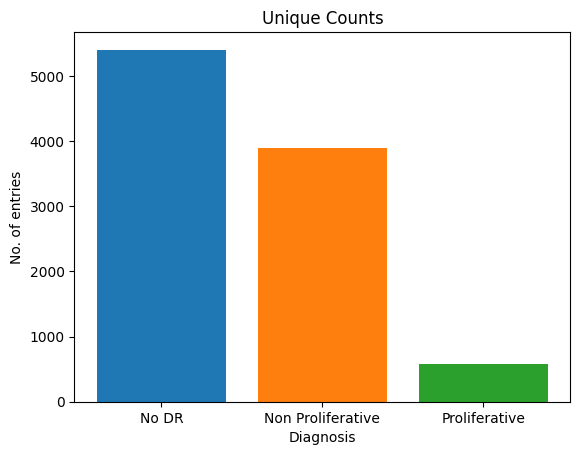

In [10]:
print_unique_counts(unique_counts)

<p>Image Enhancement techniques</p>

In [11]:
#image_files = os.listdir(root)
#x_train = [cv2.cvtColor(cv2.imread(os.path.join(root, file), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB) for file in image_files]

<p>First we are going to isolate the green channel of the images</p>

In [12]:
def print_channels(x_train):
    idx = 200
    plt.imshow(x_train[idx][:, :, 0], cmap='gray')
    plt.title("red channel")
    plt.show()
    plt.imshow(x_train[idx][:, :, 1], cmap='gray')
    plt.title("green channel")
    plt.show()
    plt.imshow(x_train[idx][:, :, 2], cmap='gray')
    plt.title("blue channel")
    plt.show()

In [13]:
#print_channels(x_train)

In [14]:
#isolate the green channel in every image
#x_train = np.array([x_train[i][:, :, 1] for i in range(len(x_train))])

In [15]:
#save all images in x_train into a new directory called 'enhanced_images' and another called iso_green_channel and convert them to .jpg files
new_dir1 = 'C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMIND2024_Dataset/enhanced_images'
new_dir2 = 'C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMIND2024_Dataset/iso_green_channel'

#for i in range(len(x_train)):
#    cv2.imwrite(os.path.join(new_dir1, image_files[i]), x_train[i])
#    cv2.imwrite(os.path.join(new_dir2, image_files[i]), x_train[i])

<p>Now we are going to apply a median filter to the enhanced grayscale images</p>

In [16]:
# Apply median filter with a specified filter size
#filtered_array = median_filter(x_train[230][:, :, 1], size=3)

# Convert the filtered array back to an image
#filtered_image = Image.fromarray(filtered_array)

In [17]:
def print_filtered_images(x_train, filtered_array):
    plt.imshow(x_train[230])
    plt.title("3 channels image")
    plt.show()
    plt.imshow(x_train[230][:, :, 1], cmap='gray')
    plt.title("green before median filter")
    plt.show()
    plt.imshow(filtered_array, cmap='gray')
    plt.title("after median filter")
    plt.show()

In [18]:
#print_filtered_images(x_train, filtered_array)

In [19]:
#apply median filter to all images
def apply_median_filter(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        if filename.endswith(".jpg"):  
            img_path = os.path.join(input_dir, filename)
            img = cv2.imread(img_path)

            # Convert BGR to RGB
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Apply median filter
            filtered_img = median_filter(img_rgb, size=3)

            # Convert RGB to BGR for saving
            filtered_img_bgr = cv2.cvtColor(filtered_img, cv2.COLOR_RGB2BGR)

            # Save filtered image
            cv2.imwrite(os.path.join(output_dir, filename), filtered_img_bgr)

In [20]:
output_dir = "C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMIND2024_Dataset/enhanced_med_clahe_images"
#save all images in x_train into a new directory called 'median_filter_images' and convert them to .jpg files
#apply_median_filter(root, output_dir)

<p>We are now going to apply a Contrast Limited Adaptive Histogram to the images</p>

In [21]:
def enhance_luminance(image, gamma=1/2.2):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    v_channel = hsv_image[:, :, 2]
    normalized_v = v_channel / 255.0
    gamma_corrected_v = np.power(normalized_v, gamma)
    enhanced_v = (gamma_corrected_v * 255.0).astype(np.uint8)
    hsv_image[:, :, 2] = enhanced_v
    enhanced_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
    return enhanced_image

In [22]:
def enhance_contrast(image, gamma=1/2.2, clip_limit=3, tiles=(4, 4)):
    enhanced_image = enhance_luminance(image, gamma)
    lab_image = cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2Lab)
    l_channel = lab_image[:, :, 0]
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tiles)
    enhanced_l_channel = clahe.apply(l_channel)
    lab_image[:, :, 0] = enhanced_l_channel
    enhanced_image = cv2.cvtColor(lab_image, cv2.COLOR_Lab2BGR)
    return enhanced_image

In [23]:
def process_images(directory, final_directory):
    for filename in os.listdir(directory):
        image_path = os.path.join(directory, filename)
        image = cv2.imread(image_path)
        enhanced_contrast_image = enhance_contrast(image)
        cv2.imwrite(os.path.join(final_directory, filename), enhanced_contrast_image)

In [24]:
CLAHE_dir = 'C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMIND2024_Dataset/CLAHE_images'
input_dir = 'C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMIND2024_Dataset/median_filter_images'
#process_images(input_dir, output_dir)

<p>Work on finalized labels</p>

In [25]:
#Reformat the labels for enhanced images
#df = pd.read_csv('C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMIND2024_Dataset/new_dataset.csv', header=None)

#df[0] = df[0].str.replace('new_dataset_images', 'enhanced_images')
#df.to_csv('C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMIND2024_Dataset/enhanced_dataset.csv', index=False, header=False)

In [26]:
#Create a combined csv file which combines the contents of the original csv file and the enhanced csv file
#df1 = pd.read_csv('C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMIND2024_Dataset/new_dataset.csv', header=None)
#df2 = pd.read_csv('C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMIND2024_Dataset/enhanced_dataset.csv', header=None)

#df3 = pd.concat([df1, df2])

#add column names to the combined csv file 
#df3.columns = ['filename', 'label']
#df3.to_csv('C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMIND2024_Dataset/combined_dataset.csv', index=False)

In [27]:
labels_df = pd.read_csv('C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMIND2024_Dataset/balanced_new_dataset_and_enhanced_med_clahe.csv')

In [28]:
unique_counts = labels_df['label'].value_counts()
print(unique_counts)

label
0    1158
1    1158
2    1158
Name: count, dtype: int64


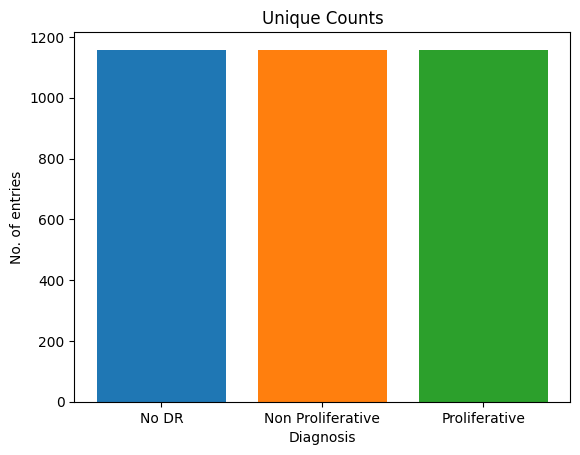

In [29]:
print_unique_counts(unique_counts)

<p>Image Augmentation techniques</p>

In [30]:
Train_Generator = ImageDataGenerator(rescale=1./255,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    validation_split=0.2)

In [31]:
Train_IMG_Set = Train_Generator.flow_from_dataframe(dataframe=labels_df,
                                                   x_col="filename",
                                                   y_col="label",
                                                   color_mode="grayscale",
                                                   class_mode="raw",
                                                   batch_size = 50,
                                                   subset="training")

Found 2780 validated image filenames.


In [32]:
validation_IMG_Set = Train_Generator.flow_from_dataframe(dataframe=labels_df,
                                                   x_col="filename",
                                                   y_col="label",
                                                   color_mode="grayscale",
                                                   class_mode="raw",
                                                   batch_size = 50,
                                                   subset="validation")

Found 694 validated image filenames.


In [33]:
total_train_images = Train_IMG_Set.n
print(f"Total number of training images: {total_train_images}")

total_validation_images = validation_IMG_Set.n
print(f"Total number of validation images: {total_validation_images}")

Total number of training images: 2780
Total number of validation images: 694


In [34]:
for i, (images, labels) in enumerate(Train_IMG_Set):
    print(f"Batch {i}, Image batch shape: {images.shape}, Labels batch shape: {labels.shape}")
    if i == 1: 
        break

Batch 0, Image batch shape: (50, 256, 256, 1), Labels batch shape: (50,)
Batch 1, Image batch shape: (50, 256, 256, 1), Labels batch shape: (50,)


50


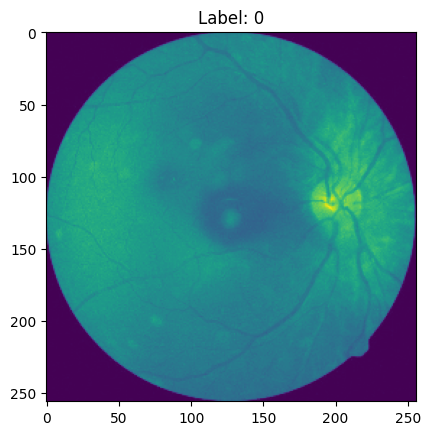

In [35]:
images, labels = next(Train_IMG_Set)
print(len(images))

for i in range(1): 
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.show()

In [36]:
# Initialize lists to store the images and labels
train_images = []
train_labels = []

# Iterate over the generator
for img_batch, label_batch in Train_IMG_Set:
    train_images.extend(img_batch)
    train_labels.extend(label_batch)
    
    # Break the loop once we've gone through all the data
    if Train_IMG_Set.batch_index == 0:
        break

# Convert the lists to numpy arrays
X_train = np.array(train_images)
y_train = np.array(train_labels)

In [37]:
# Initialize lists to store the images and labels
valid_images = []
valid_labels = []

# Iterate over the generator
for img_batch, label_batch in validation_IMG_Set:
    valid_images.extend(img_batch)
    valid_labels.extend(label_batch)
    
    # Break the loop once we've gone through all the data
    if validation_IMG_Set.batch_index == 0:
        break

# Convert the lists to numpy arrays
X_valid = np.array(valid_images)
y_valid = np.array(valid_labels)

In [38]:
#using Train_IMG_Set and validation_IMG_Set create a model that can classify the images into the 3 classes
def create_model(optimizer='adam'):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=(256, 256, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (2, 2)),
        tf.keras.layers.MaxPooling2D(2, 2), 
        tf.keras.layers.Conv2D(128, (2, 2)),
        tf.keras.layers.MaxPooling2D(2, 2), 
        tf.keras.layers.Conv2D(256, (2, 2)),
        tf.keras.layers.MaxPooling2D(2, 2), 
        tf.keras.layers.Conv2D(512, (2, 2)),
        tf.keras.layers.MaxPooling2D(2, 2), 
        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dense(256, activation='relu'), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'), 
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(model=create_model, verbose=1)

# define the grid search parameters
param_grid = {'batch_size': [32, 64],
              'epochs': [25, 30],
              'optimizer': ['SGD', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=3)
grid_result = grid.fit(X_train, y_train, validation_data=(X_valid, y_valid))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Epoch 1/25
55/55 [==============================] - 4s 43ms/step - loss: 1.0817 - accuracy: 0.4341 - val_loss: 1.5370 - val_accuracy: 0.0000e+00
Epoch 2/25
55/55 [==============================] - 2s 34ms/step - loss: 1.0361 - accuracy: 0.4347 - val_loss: 1.4111 - val_accuracy: 0.1513
Epoch 3/25
55/55 [==============================] - 2s 34ms/step - loss: 1.0298 - accuracy: 0.4392 - val_loss: 2.0337 - val_accuracy: 0.0000e+00
Epoch 4/25
55/55 [==============================] - 2s 34ms/step - loss: 0.9898 - accuracy: 0.4666 - val_loss: 1.1798 - val_accuracy: 0.3012
Epoch 5/25
55/55 [==============================] - 2s 34ms/step - loss: 0.9620 - accuracy: 0.5048 - val_loss: 1.1430 - val_accuracy: 0.4755
Epoch 6/25
55/55 [==============================] - 2s 34ms/step - loss: 0.9059 - accuracy: 0.5459 - val_loss: 1.5502 - val_accuracy: 0.2349
Epoch 7/25
55/55 [==============================] - 2s 34ms/step - loss: 0.8681 - acc

In [39]:
#analyze the results of the grid search 
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=50)

#model.save('C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMIND2024_Dataset/DR_model.h5')

#model = tf.keras.models.load_model('C:/Users/siyun/OneDrive/Desktop/QMIND 2024/QMIND2024_Dataset/DR_model.h5')

#model.evaluate(X_valid, y_valid)
    
#model.summary()
    

Best: 0.649821 using {'batch_size': 64, 'epochs': 30, 'optimizer': 'Adam'}
0.624721 (0.012956) with: {'batch_size': 32, 'epochs': 25, 'optimizer': 'SGD'}
0.614446 (0.013866) with: {'batch_size': 32, 'epochs': 25, 'optimizer': 'Adagrad'}
0.615216 (0.013801) with: {'batch_size': 32, 'epochs': 25, 'optimizer': 'Adadelta'}
0.641828 (0.007286) with: {'batch_size': 32, 'epochs': 25, 'optimizer': 'Adam'}
0.601899 (0.010659) with: {'batch_size': 32, 'epochs': 25, 'optimizer': 'Adamax'}
0.562368 (0.032061) with: {'batch_size': 32, 'epochs': 25, 'optimizer': 'Nadam'}
0.595067 (0.024532) with: {'batch_size': 32, 'epochs': 30, 'optimizer': 'SGD'}
0.614835 (0.016783) with: {'batch_size': 32, 'epochs': 30, 'optimizer': 'Adagrad'}
0.600753 (0.013419) with: {'batch_size': 32, 'epochs': 30, 'optimizer': 'Adadelta'}
0.617886 (0.028070) with: {'batch_size': 32, 'epochs': 30, 'optimizer': 'Adam'}
0.620533 (0.007075) with: {'batch_size': 32, 'epochs': 30, 'optimizer': 'Adamax'}
0.622816 (0.006625) with: {'